# LangChain version:

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model="models/gemini-3-pro-preview", temperature=0.7)
llm = ChatGoogleGenerativeAI(model="models/gemini-2.5-pro", temperature=0.7)
llm

ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, model='models/gemini-2.5-pro', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x10cc4a660>, default_metadata=(), model_kwargs={})

In [3]:
PPT_FILE_NAME = "generated_ppt_code.py"

## PPT code gen:

In [4]:
from langchain.tools import tool
from langchain_core.prompts import ChatPromptTemplate

In [5]:
CONTEXT_DOCS = open("./pptx_docs/merged_docs_edit.md", "r").read()
CONTEXT_DOCS[:75]

'# Getting Started — python-pptx 1.0.0 documentation\nA quick way to get star'

In [6]:
ppt_generate_template = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant that generates Python code using the python-pptx library.
    Your task: Create a complete Python script that builds a PowerPoint presentation about the topic: "{user_query}"

    # Requirements:
    1. The presentation must contain {target_slides} slides.
    2. Use only features supported by python-pptx.
    3. Slides must include:
        - Title and content text
        - At least **one table**
        - A **bar chart**
        - A **pie chart**
        - (Optional) another chart type supported by python-pptx
    4. For images:
        - Do NOT embed real images.
        - Insert placeholder rectangles OR image placeholders.
        - Add captions/alt-text describing the intended image (e.g., "Image: workflow diagram here").
    5. Structure code cleanly:
        - Import all needed modules.
        - Create presentation, slides, chart data, tables, and placeholders.
        - Save output as `output.pptx`.
        - After saving, print "Presentation 'output.pptx' created successfully."

    # Context
    {context_docs_dump}
    """),
    ("user", "Please generate a ppt on topic: `{user_query}`. Details: {other_details}."),
])

ppt_generation_chain = ppt_generate_template | llm

In [7]:
def extract_code_block(markdown_text:str) -> str | None:
    """Extract the content in code block from markdown text. Only one code block is expected."""
    import re
    code_block_pattern = r"```(?:python)?\n(.*?)\n```"
    match = re.search(code_block_pattern, markdown_text, re.DOTALL)
    if match:
        return match.group(1)
    return None

In [8]:
saved_resp = ""

In [9]:
@tool
def create_ppt_tool(topic: str, others: str | None, slide_count: int | None) -> str:
    """This tool generates a Python script using python-pptx to create a PowerPoint presentation on the given topic. The arguments are:

    Arguments:
        topic (str): The topic of the presentation.
        others (optional, str): Any other requirements or details.
        slide_count (optional, int): Minimum number of slides required.
    Returns:
        str: The generated Python script as a string.
    """
    slide_count = slide_count if slide_count else 10

    resp = ppt_generation_chain.invoke({  # type: ignore
        "user_query": topic,
        "target_slides": f"at least {slide_count}",
        "context_docs_dump": CONTEXT_DOCS,
        "other_details": others if others else "Nothing."
    })
    saved_resp = resp  # debugging purpose
    resp = resp.text
    try:
        code_resp = extract_code_block(resp)
        if code_resp:
            return code_resp
        else:
            return "Could not extract code block from the response."
    except Exception as e:
        return f"Error extracting code: {str(e)}"

In [10]:
# # Test Run:
# resp = create_ppt.invoke({
#     "topic": "Tea in India",
#     "others": "Include statistics about tea production and consumption."
# })

# with open("generated_ppt_code.py", "w", encoding="utf-8") as f:
#     f.write(resp)

## Execute Code Tool:

In [11]:
@tool
def execute_code_tool(code: str) -> str:
    """This tool saves the provided Python code to a file and executes it to generate the PowerPoint presentation. In return it shall return output message from the execution. Either success message or error details.

    Arguments:
        code (str): The Python code to execute.
    Returns:
        str: The output message from the execution.
    """
    with open(PPT_FILE_NAME, "w", encoding="utf-8") as f:
        f.write(code)

    import subprocess
    try:
        result = subprocess.run(
            ["python", PPT_FILE_NAME],
            capture_output=True,
            text=True,
            check=True
        )
        return result.stdout
    
    except subprocess.CalledProcessError as e:
        return f"Error executing code: {e.stderr}"

In [12]:
# resp = open("./temp_err_code.py", "r", encoding="utf-8").read()
# resp = open("./temp_success_code.py", "r", encoding="utf-8").read()
# execute_code_tool.invoke({
#     "code": resp
# })

## Debug Code Tool:

In [13]:
debug_system_prompt = """You are an expert debugger who works on fixing Python code that uses the python-pptx library.

Given the erroneous code and the error message from its execution, your task is to fix the code so that it runs without errors and generates the intended PowerPoint presentation. 
- If the solution is complex of might need uncertain steps, just try to avoid that section and provide a simpler alternative.
- Your response should contain complete fixed code from start to end. Do not include any explanations or notes or other snippets.

# Code:
```python
{code_block}
```

# Error:
{error_message}

# Context
{context_docs_dump}
"""

code_debug_template = ChatPromptTemplate.from_messages([
    ("system", debug_system_prompt),
    ("user",
     "Please debug and fix the above code so that it runs without errors and generates the intended PowerPoint presentation about the topic: '{user_query}'."),
])

code_debug_chain = code_debug_template | llm
# print(code_debug_template.messages[0].prompt.template)

In [14]:
saved_resp = ""

In [15]:
@tool
def debug_code_tool(error_message: str, ppt_topic: str) -> str:
    """This tool is used to debug the generated codes if any error occurs during execution. It reads the code saved from the python file, and attempts fix the code with LLM again. No need to pass code as argument, as it is read from the saved file directly.

    Arguments:
        error_message (str): The error message from the previous code execution.
        ppt_topic (str): The topic of the PowerPoint presentation being generated.
    Returns:
        str: New code to save and execute.
    """
    wrong_code = ""
    with open(PPT_FILE_NAME, "r", encoding="utf-8") as f:
        wrong_code = f.read()

    resp = code_debug_chain.invoke({  # type: ignore
        "code_block": wrong_code,
        "error_message": error_message,
        "context_docs_dump": CONTEXT_DOCS,
        "user_query": ppt_topic
    })
    resp = resp.text
    saved_resp = resp  # debugging purpose

    try:
        code_resp = extract_code_block(resp)
        if code_resp:
            return code_resp
        else:
            return "Could not extract code block from the response."
    except Exception as e:
        return f"Error extracting code: {str(e)}"

In [16]:
# resp = open("./temp_err_code_simple.py", "r", encoding="utf-8").read()
# debug_code_tool.invoke({
#     "error_message": "File temp_err_code_simple.py, line 11 \n subtitle.text = \"This is a minimal python-pptx example. \n ^ \n SyntaxError: unterminated string literal (detected at line 11)AttributeError: 'ChartData' object has no attribute 'add_series'",
#     "ppt_topic": "Tea in India"
# })

## Final Boss:

In [17]:
from langchain.agents import create_agent

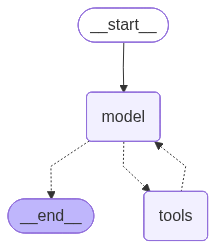

In [18]:
ppt_maker_agent = create_agent(
    name="PPT Maker Agent",
    model=llm,
    system_prompt="You are an expert in making PPTs for any given topic. You can ask follow up questions to clarify user requirements before generating the PPT. You will be provided with some tools to help you generate the PPTs effectively. You can use them multiple times as needed. At the end of your work, return a string sating `Done` or `Failed`.",
    tools=[create_ppt_tool, execute_code_tool, debug_code_tool]
)
ppt_maker_agent

In [19]:
# agent will need:
# 1. topic for ppt, 2. any other details, 3. slide count

In [20]:
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.messages import HumanMessage, AIMessage
# from langchain_core.runnables.history import RunnableWithMessageHistory

In [21]:
store = {}
def get_session_history(session_id: str | int) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

get_session_history(15).messages

[]

In [22]:
def add_message_to_history(session_id: str | int, message: str, type: str) -> None:
    # session_id, text message, type: "human" | "ai"
    history = get_session_history(session_id)
    if type == "human":
        history.add_user_message(message=message)
    else:
        history.add_ai_message(message=message)
        
add_message_to_history(15, "Hello", "human")
get_session_history(15).messages

[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={})]

In [23]:
def ask_something(session_id: str | int, user_input: str) -> str:
    """Main function to continue any past chat session or start a new one."""
    history = get_session_history(session_id)

    final_response = ppt_maker_agent.invoke(
        input={
            "messages": history.messages + [HumanMessage(content=user_input)]
        }  # type: ignore
    )

    # print(final_response)
    final_response = final_response['messages'][-1]
    final_response = final_response.text

    # Update history
    add_message_to_history(session_id, user_input, "human")
    add_message_to_history(session_id, final_response, "ai")

    # Answer:
    return final_response

In [24]:
from IPython.display import Markdown

In [25]:
ask_something(10, "Hello")

'Of course, hello! What topic would you like your PowerPoint presentation on?'

In [26]:
Markdown(
    ask_something(10, "Can we work on Programming Languages?")
)

Great! "Programming Languages" is a broad topic. To make the presentation more focused, could you tell me:

*   Who is the target audience? (e.g., beginners, experienced developers)
*   Are there any specific programming languages you'd like to include?
*   How many slides should the presentation have?

In [27]:
Markdown(
    ask_something(10, "I want main 3-4 languages. 9 slides. My main purpose is to see how popularity has changed over time. What is their market share? Can you first finalize the languages with me?")
)

Excellent idea. That will make for a very interesting presentation.

Based on historical data and current market relevance, I suggest we focus on these three languages:

1.  **Java:** A dominant force for decades, especially in enterprise applications. Its popularity trend is a great story.
2.  **Python:** Has seen a meteoric rise, particularly with the growth of data science, machine learning, and AI.
3.  **JavaScript:** The undisputed king of the web, its evolution from a simple scripting language to a full-stack solution (with Node.js) is a fascinating journey.

These three give us a fantastic narrative of stability, rapid growth, and domain-specific dominance.

How do these sound to you? We can add a fourth, like C++, if you'd like to include a language with deep roots in systems programming.

In [29]:
Markdown(ask_something(10, "Consider C++ also. Now generate"))

Done

In [30]:
get_session_history(10).messages

[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='b2724eb9-8a2a-4981-aab5-603e7d48ff07'),
 AIMessage(content='Of course, hello! What topic would you like your PowerPoint presentation on?', additional_kwargs={}, response_metadata={}, id='b079a992-6923-4b40-9508-a37f614a04d2'),
 HumanMessage(content='Can we work on Programming Languages?', additional_kwargs={}, response_metadata={}, id='70865eed-2191-487d-8161-9c2102b21674'),
 AIMessage(content='Great! "Programming Languages" is a broad topic. To make the presentation more focused, could you tell me:\n\n*   Who is the target audience? (e.g., beginners, experienced developers)\n*   Are there any specific programming languages you\'d like to include?\n*   How many slides should the presentation have?', additional_kwargs={}, response_metadata={}, id='6b0715ef-5439-4c25-a34a-78dcc3dc673d'),
 HumanMessage(content='I want main 3-4 languages. 9 slides. My main purpose is to see how popularity has changed over time. 